<a href="https://colab.research.google.com/github/joanmaller/btbs/blob/main/Cross_task_EEG_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> Biometrich Technologies and Behavioural Security </center>





# **<center>Cross-task EEG recognition </center>**
<center> Joan Maller </center>


Implement two personal recognizers based on the EEG signal, one using a 2D-CNN and the other with a 1D-CNN (https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf), explaining through comments the various steps performed.



Use the EEG Motor Movement/Imagery Dataset (sample rate is 160 Hz).

Download the dataset using the shared Google Drive folder (zip) with ID equal to 

1GAREa3Y0k7O1OW9PhugqHL90TbFbQlwJ

The data are provided in EDF+ format. Each annotation includes one of two codes (T0, T1):

T0 corresponds to rest.

T1 corresponds to onset of motion (real or imagined) of the left fist.

Perform a db analysis, printing the number of classes and the number of samples per class.

Using the broadband, analyzes the performance of the two systems in cross-task (train on a task type recordings and test on the other).

Compare the two results in terms of accuracy.

##Step 1: Download Dataset

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pandas import read_csv
from numpy import mean
from numpy import std
from numpy import delete
from numpy import savetxt
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import sys
import time
from IPython.display import HTML, display
from IPython.display import clear_output
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
downloaded = drive.CreateFile({'id': '1GAREa3Y0k7O1OW9PhugqHL90TbFbQlwJ'})
downloaded.GetContentFile('dataset.zip')
!unzip dataset

Archive:  dataset.zip
   creating: EEG_cross/
   creating: EEG_cross/T0/
  inflating: EEG_cross/T0/S001R01.edf  
  inflating: EEG_cross/T0/S002R01.edf  
  inflating: EEG_cross/T0/S003R01.edf  
  inflating: EEG_cross/T0/S004R01.edf  
  inflating: EEG_cross/T0/S005R01.edf  
  inflating: EEG_cross/T0/S006R01.edf  
  inflating: EEG_cross/T0/S007R01.edf  
  inflating: EEG_cross/T0/S008R01.edf  
  inflating: EEG_cross/T0/S009R01.edf  
  inflating: EEG_cross/T0/S010R01.edf  
  inflating: EEG_cross/T0/S011R01.edf  
  inflating: EEG_cross/T0/S012R01.edf  
  inflating: EEG_cross/T0/S013R01.edf  
  inflating: EEG_cross/T0/S014R01.edf  
  inflating: EEG_cross/T0/S015R01.edf  
  inflating: EEG_cross/T0/S016R01.edf  
  inflating: EEG_cross/T0/S017R01.edf  
  inflating: EEG_cross/T0/S018R01.edf  
  inflating: EEG_cross/T0/S019R01.edf  
  inflating: EEG_cross/T0/S020R01.edf  
   creating: EEG_cross/T1/
  inflating: EEG_cross/T1/S001R03.edf  
  inflating: EEG_cross/T1/S002R03.edf  
  inflating: EEG_cro

In [ ]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 7.3 MB/s 


## Step 2: Separate into training and testing


At first I separated the database into T0 for training and T1 for testing, but I did not have good results. So I separated both T0 and T1 into

In [ ]:
import mne

train_f = os.listdir('/content/EEG_cross/T0')
test_f = os.listdir('/content/EEG_cross/T1')
train_t0 = []
train_t1 = []
y_tr_t0 = []
y_tr_t1 = []
test_t1 = []
test_t0 = []
y_test_t0 = []
y_test_t1 = []

test_t0_nr = [] #Not reshaped data to extract images from them
train_t0_nr = []
test_t1_nr = []
train_t1_nr = []

classe = 0
 
# Patch length --> 160 samples == 1 second 
l_patch = 160
 
 
path = '/content/EEG_cross/T0/'
path_test = '/content/EEG_cross/T1/'
 
# Split into 5 frequency bands
high = {'alpha' : 13, 'beta' : 30, 'delta' : 4, 'gamma' : 40, 'theta' : 8, 'broadband' : None } # High frequencies
low = {'alpha' : 8, 'beta' : 13, 'delta' : 0.5, 'gamma' : 30, 'theta' : 4, 'broadband' : 1 } # Low frequencies
 
 
ntr = 50 # train set sample seconds 
nts = 10 # test set sample seconds 

#We prepare the train array
for i in train_f:
  
  r0 = mne.io.read_raw_edf(input_fname = path+i, preload = True, verbose = 'CRITICAL')
  eegobjects = (mne.io.Raw.filter(r0, l_freq = low['broadband'], h_freq = high['broadband'], n_jobs = 8, verbose = 'CRITICAL'))
  registrazione = eegobjects.get_data()
  h = l_patch
  l = 0
  
  while h <= (ntr*160):
    train_t0_nr.append(registrazione[:,l:h])
    train_t0.append(registrazione[:,l:h].reshape(64*l_patch))
    y_tr_t0.append(classe)
    l = l + l_patch
    h = h + l_patch
 
  while h <= ((ntr+nts)*160):
    test_t0_nr.append(registrazione[:,l:h])
    test_t0.append(registrazione[:,l:h].reshape(64*l_patch))
    y_test_t0.append(classe)
    l = l + l_patch
    h = h + l_patch
  classe = classe + 1

#And the test array
classe = 0
for i in test_f:
  
  r_t = mne.io.read_raw_edf(input_fname = path_test+i, preload = True, verbose = 'CRITICAL')
  eegobjects = (mne.io.Raw.filter(r_t, l_freq = low['broadband'], h_freq = high['broadband'], n_jobs = 8, verbose = 'CRITICAL'))
  registrazione_test = eegobjects.get_data()
  h = l_patch
  l = 0
  
  while h <= (ntr*160):
    train_t1_nr.append(registrazione_test[:,l:h])
    train_t1.append(registrazione_test[:,l:h].reshape(64*l_patch))
    y_tr_t1.append(classe)
    l = l + l_patch
    h = h + l_patch

  while h <= ((ntr+nts)*160):
    test_t1_nr.append(registrazione_test[:,l:h])
    test_t1.append(registrazione[:,l:h].reshape(64*l_patch))
    y_test_t1.append(classe)
    l = l + l_patch
    h = h + l_patch
  classe = classe + 1


In [ ]:
print(len(y_tr_t0)) #50 seconds for 20 subjects
print(len(y_tr_t1))

print(y_tr_t0 == y_tr_t1) #We check that the label 


1000
1000
True


(64, 9760)


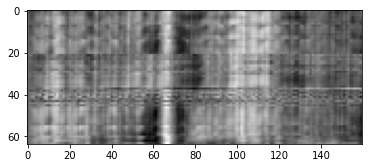

In [ ]:
print(registrazione.shape)
plt.imshow(train_t0_nr[0], cmap = 'gray')

(64, 19680)


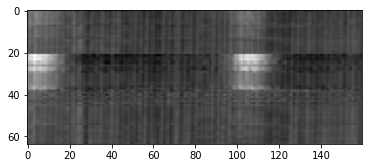

In [ ]:
print(registrazione_test.shape)

plt.imshow(test_t1_nr[0], cmap = 'gray')

In [ ]:
print(len(train_t0), len(train_t0[0]))
print(len(test_t0), len(test_t0[0]))
print(len(train_t0_nr), len(train_t0_nr[0]), len(train_t0_nr[0][0]))
print(len(train_t1_nr), len(train_t1_nr[0]))

1000 10240
200 10240
1000 64 160
1000 64


## Step 3: Feature Extraction

###Step 3.1 Define LBP function

In [ ]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
     
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top
    
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

In [ ]:
X_tr = []
for k in train_t0:
  img_lbp = np.zeros((64, l_patch,3), np.uint8)
  for i in range(0, 64):
    for j in range(0, l_patch):
      img_lbp[i, j] = lbp_calculated_pixel(k.reshape(64,l_patch), i, j)
  hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
  hist_lbp = hist_lbp.astype("float")
  hist_lbp /= (hist_lbp.sum() + 1e-7)
  X_tr.append(hist_lbp)
X_tr = np.array(X_tr)[:,:,0]

In [ ]:
X_ts = []
for k in test_t0:
  img_lbp = np.zeros((64, l_patch,3), np.uint8)
  for i in range(0, 64):
    for j in range(0, l_patch):
      img_lbp[i, j] = lbp_calculated_pixel(k.reshape(64,l_patch), i, j)
  hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
  hist_lbp = hist_lbp.astype("float")
  hist_lbp /= (hist_lbp.sum() + 1e-7)
  X_ts.append(hist_lbp)
X_ts = np.array(X_ts)[:,:,0]

In [ ]:
X_tr_t1 = []
for k in train_t1:
  img_lbp = np.zeros((64, l_patch,3), np.uint8)
  for i in range(0, 64):
    for j in range(0, l_patch):
      img_lbp[i, j] = lbp_calculated_pixel(k.reshape(64,l_patch), i, j)
  hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
  hist_lbp = hist_lbp.astype("float")
  hist_lbp /= (hist_lbp.sum() + 1e-7)
  X_tr_t1.append(hist_lbp)
X_tr_t1 = np.array(X_tr_t1)[:,:,0]

In [ ]:
X_ts_t1 = []
for k in test_t1:
  img_lbp = np.zeros((64, l_patch,3), np.uint8)
  for i in range(0, 64):
    for j in range(0, l_patch):
      img_lbp[i, j] = lbp_calculated_pixel(k.reshape(64,l_patch), i, j)
  hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
  hist_lbp = hist_lbp.astype("float")
  hist_lbp /= (hist_lbp.sum() + 1e-7)
  X_ts_t1.append(hist_lbp)
X_ts_t1 = np.array(X_ts_t1)[:,:,0]

##Step 4: Classifying on simple SVM

We check that the SVM classifier works comparing it with the same data (t0 and t0)

In [ ]:
from sklearn import svm 
clf = svm.SVC()
clf.fit(X_tr, y_tr_t0)

print(y_tr_t0)
print(y_test_t0)


y_pred = clf.predict(X_ts)
print(y_pred)

from sklearn.metrics import accuracy_score
acc='Linear SVC Accuracy of T0 on T0: %.2f %%' % (accuracy_score(y_test_t0, y_pred)*100)
print(acc)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_t0, y_pred))


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6

With an accuracy of 89.5% classifies correctly the subject within the same task (T0)

In [ ]:
y_pred2 = clf.predict(X_ts_t1)
acc2='Linear SVC Accuracy of T0 on T1: %.2f %%' % (accuracy_score(y_test_t1, y_pred2)*100)
print(acc2)
print(y_pred2)
print(confusion_matrix(y_test_t1, y_pred2))


Linear SVC Accuracy of T0 on T1: 5.00 %
[19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0 

When we try the same SVM classifier but applying it to T1 test, all subjects are recognized as the last subject, giving us a 5% precision. 

In [ ]:
#We make another SVC classifier trained on T1 data to try it on T0 and t1, to see if it improves
clf2 = svm.SVC()
clf2.fit(X_tr_t1, y_tr_t1)
y_pred3 = clf2.predict(X_ts)
y_pred4 = clf2.predict(X_ts_t1)

acc3='Linear SVC Accuracy of T1 on T0: %.2f %%' % (accuracy_score(y_test_t0, y_pred3)*100)
print(acc3)
print(y_pred3)
print(confusion_matrix(y_test_t0, y_pred3))

print('\n')
acc4='Linear SVC Accuracy of T1 on T1: %.2f %%' % (accuracy_score(y_test_t1, y_pred4)*100)
print(acc4)
print(y_pred4)
print(confusion_matrix(y_test_t1, y_pred4))

Linear SVC Accuracy of T1 on T0: 2.00 %
[ 7  7  7  7  7  7  7  7  7  7 10 10 10 10 10 10 10 10 10 10 15 15 15 15
 15 15 15 15 15 15  1  1  1  1 19 19 19 19  1 19  6  6  6  6  9  6  6  6
  9 13 18 18 18 18 18  9 18 18 18 14  2  2  2  2  2  2  2  2  2  2 12 12
 12 17 15 12 17 17 17 12 16 16 16 16 16 16 16 16 16 16 13 13 13 13 13 13
 13 13  1 13 12 12 12 12 12 12 12 12 12 12 17 11 17 17 17 11 17 11 17 11
  8  1 18  8 18  6  8 18 18  8  9 15 12 12  9  9  9  9 15  9  3  3  3  3
  3  3  3  3  0  3 19 13 13  8 13 13 13 13 13 19 19 19 19 19 19 19 19 19
 19 19  5  5  5  5  5  0  5  5  0  5  4  4  4  4  4  4  4  4  4  4  0  0
  0  0  0  0  0  0  0  0]
[[ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  7  0  0  2  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 

## Step 5: Classifying on 2d CNN

Prepare data for classifiers

In [ ]:
import keras

#We convert lists to numpy arrays
X_tr = np.array(X_tr)
y_tr_t0 = np.array(y_tr_t0)
X_ts = np.array(X_ts)
y_test_t0 = np.array(y_test_t0)
X_tr_t1 = np.array(X_tr_t1)
y_tr_t1 = np.array(y_tr_t1)
X_ts_t1 = np.array(X_ts_t1)
y_test_t1 = np.array(y_test_t1)
train_t0_nr = np.array(train_t0_nr)
train_t1_nr = np.array(train_t1_nr)
test_t0_nr = np.array(test_t0_nr)
test_t1_nr = np.array(test_t1_nr)

#We convert labels to categorical
num_classes = 20

y_tr_t0_cat = keras.utils.np_utils.to_categorical(y_tr_t0, num_classes)
y_tr_t1_cat = keras.utils.np_utils.to_categorical(y_tr_t1, num_classes)
y_test_t0_cat = keras.utils.np_utils.to_categorical(y_test_t0, num_classes)
y_test_t1_cat = keras.utils.np_utils.to_categorical(y_test_t1, num_classes)

print('X_tr shape: ', np.shape(X_tr))
print('X_tr_t1 shape: ', np.shape(X_tr_t1))
print('y_tr_t0 shape: ', np.shape(y_tr_t0))
print('X_ts shape: ', np.shape(X_ts))
print('X_ts_t1 shape: ', np.shape(X_ts_t1))
print('y_test_t0 shape: ', np.shape(y_test_t0))
print('train_t0_nr shape: ', np.shape(train_t0_nr))
print('y_test_t0_cat shape: ', np.shape(y_test_t0_cat))

X_tr shape:  (1000, 256)
X_tr_t1 shape:  (1000, 256)
y_tr_t0 shape:  (1000,)
X_ts shape:  (200, 256)
X_ts_t1 shape:  (200, 256)
y_test_t0 shape:  (200,)
train_t0_nr shape:  (1000, 64, 160)
y_test_t0_cat shape:  (200, 20)


I found that the 2D CNN worked best when I put the LBP code into a 16x16 matrix, instead of inputting the image (not-reshaped data)

In [ ]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from keras.models import Sequential, Model, load_model, model_from_yaml


model = Sequential()
model.add(Reshape((16, 16, 1),input_shape=(None, 256)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(20))
model.add(Activation('softmax')) 

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

history=model.fit(X_tr, y_tr_t0_cat,
          batch_size=20,
          epochs=100,
          verbose=1,
          validation_data=(X_ts, y_test_t0_cat))

Epoch 1/100
50/50 [==============================] - 1s 15ms/step - loss: 2.9956 - accuracy: 0.0430 - val_loss: 2.9911 - val_accuracy: 0.0500
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: 2.9829 - accuracy: 0.0760 - val_loss: 2.9665 - val_accuracy: 0.0500
Epoch 3/100
50/50 [==============================] - 1s 11ms/step - loss: 2.9305 - accuracy: 0.0490 - val_loss: 2.8668 - val_accuracy: 0.0600
Epoch 4/100
50/50 [==============================] - 1s 11ms/step - loss: 2.7900 - accuracy: 0.0740 - val_loss: 2.6998 - val_accuracy: 0.1100
Epoch 5/100
50/50 [==============================] - 1s 10ms/step - loss: 2.6100 - accuracy: 0.1280 - val_loss: 2.4885 - val_accuracy: 0.2600
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 2.4464 - accuracy: 0.1970 - val_loss: 2.3263 - val_accuracy: 0.2650
Epoch 7/100
50/50 [==============================] - 1s 11ms/step - loss: 2.3276 - accuracy: 0.2050 - val_loss: 2.1877 - val_accuracy: 0.2800
Epoch 

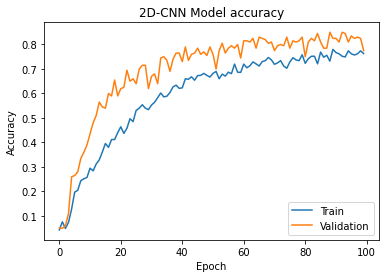

[[1.89074246e-20 4.20014884e-10 0.00000000e+00 ... 2.33082566e-02
  1.27082167e-04 9.16953206e-01]
 [1.27105688e-20 1.05932918e-09 0.00000000e+00 ... 3.69850732e-02
  4.35398892e-04 8.91390443e-01]
 [2.28544616e-22 3.20657190e-09 0.00000000e+00 ... 1.75442714e-02
  6.56219549e-04 9.56907809e-01]
 ...
 [3.42221453e-18 1.03662405e-10 1.14397635e-37 ... 3.22946087e-02
  5.22881455e-05 8.69182944e-01]
 [1.51058094e-14 6.47322647e-12 4.03648961e-30 ... 9.84441862e-02
  1.61135904e-05 6.41953111e-01]
 [9.39737328e-17 2.91154600e-11 1.19444975e-33 ... 7.67713264e-02
  7.48778548e-05 6.97890520e-01]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
2D-CNN Accuracy of T0 on T1: 5.00 %
10/10 [==============================] - 0s 3ms/step - loss: 25.9732 - accuracy: 0.0500
[25.973154067993164, 0.05000000074505806]


In [ ]:
#Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('2D-CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

scr = model.predict(X_ts_t1) # We extract the score for each class ...
print(scr)
y_pred5 = np.rint(scr)     # ... and then we round it to the nearest integer
print(y_pred5)
acc5='2D-CNN Accuracy of T0 on T1: %.2f %%' % (accuracy_score(y_test_t1_cat, y_pred5)*100)
print(acc5)
score = model.evaluate(X_ts_t1, y_test_t1_cat, batch_size=20)
print(score)


Now I try it on t1 data


In [ ]:
history2=model.fit(X_tr_t1, y_tr_t1_cat,
          batch_size=20,
          epochs=100,
          verbose=1,
          validation_data=(X_ts_t1, y_test_t1_cat))


Epoch 1/100
50/50 [==============================] - 1s 11ms/step - loss: 13.4440 - accuracy: 0.0440 - val_loss: 3.3110 - val_accuracy: 0.0500
Epoch 2/100
50/50 [==============================] - 1s 10ms/step - loss: 3.0810 - accuracy: 0.0530 - val_loss: 2.9990 - val_accuracy: 0.0500
Epoch 3/100
50/50 [==============================] - 1s 10ms/step - loss: 3.0018 - accuracy: 0.0500 - val_loss: 2.9986 - val_accuracy: 0.0500
Epoch 4/100
50/50 [==============================] - 1s 11ms/step - loss: 2.9992 - accuracy: 0.0500 - val_loss: 2.9982 - val_accuracy: 0.0500
Epoch 5/100
50/50 [==============================] - 0s 10ms/step - loss: 2.9995 - accuracy: 0.0500 - val_loss: 2.9979 - val_accuracy: 0.0500
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 2.9984 - accuracy: 0.0500 - val_loss: 2.9976 - val_accuracy: 0.0500
Epoch 7/100
50/50 [==============================] - 1s 11ms/step - loss: 2.9980 - accuracy: 0.0500 - val_loss: 2.9974 - val_accuracy: 0.0500
Epoch

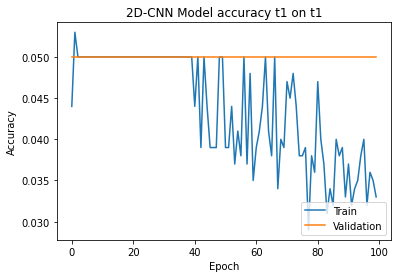

[[0.04986254 0.04989414 0.05003283 ... 0.04995483 0.05001666 0.05007672]
 [0.04986254 0.04989414 0.05003283 ... 0.04995483 0.05001666 0.05007672]
 [0.04986254 0.04989414 0.05003283 ... 0.04995483 0.05001666 0.05007672]
 ...
 [0.04986254 0.04989414 0.05003283 ... 0.04995483 0.05001666 0.05007672]
 [0.04986254 0.04989414 0.05003283 ... 0.04995483 0.05001666 0.05007672]
 [0.04986254 0.04989414 0.05003283 ... 0.04995483 0.05001666 0.05007672]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2D-CNN Accuracy of T1 on T0: 0.00 %
10/10 [==============================] - 0s 3ms/step - loss: 2.9957 - accuracy: 0.0500
[2.9957330226898193, 0.05000000074505806]


In [ ]:
#Plot Accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('2D-CNN Model accuracy t1 on t1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

scr = model.predict(X_ts) # We extract the score for each class ...
print(scr)
y_pred6 = np.rint(scr)     # ... and then we round it to the nearest integer
print(y_pred6)
acc6='2D-CNN Accuracy of T1 on T0: %.2f %%' % (accuracy_score(y_test_t0_cat, y_pred6)*100)
print(acc6)
score = model.evaluate(X_ts, y_test_t0_cat, batch_size=20)
print(score)


## Step 6: Classifying on 1D-CNN

I feed the not reshaped data, so the original registraziones 64 channels cut in batches of length 160. channels x time-series as the 1d CNN written work recommends. First I am going to train it on T0 

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_86 (Conv1D)          (None, 64, 64)            10304     
                                                                 
 conv1d_87 (Conv1D)          (None, 64, 32)            2080      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 21, 32)           0         
 g1D)                                                            
                                                                 
 dropout_67 (Dropout)        (None, 21, 32)            0         
                                                                 
 conv1d_88 (Conv1D)          (None, 12, 50)            16050     
                                                                 
 global_average_pooling1d_24  (None, 50)               0         
  (GlobalAveragePooling1D)                           

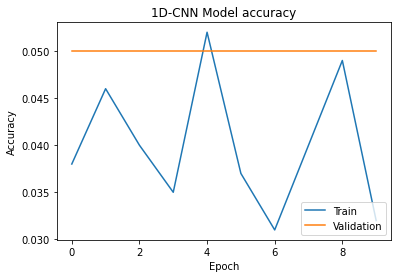

[[0.04987656 0.05009366 0.05003972 ... 0.04992995 0.04992498 0.0499885 ]
 [0.04987656 0.05009366 0.05003972 ... 0.04992995 0.04992498 0.0499885 ]
 [0.04987656 0.05009366 0.05003972 ... 0.04992995 0.04992498 0.0499885 ]
 ...
 [0.04987656 0.05009366 0.05003972 ... 0.04992995 0.04992498 0.0499885 ]
 [0.04987656 0.05009366 0.05003972 ... 0.04992995 0.04992498 0.0499885 ]
 [0.04987656 0.05009366 0.05003972 ... 0.04992995 0.04992498 0.0499885 ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1D-CNN Accuracy of T0 on T1: 0.00 %


In [ ]:
import keras
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from keras.models import Sequential, Model, load_model, model_from_yaml

model_m = Sequential()

#model_m.add(Reshape((160, 64), input_shape=(64, 160)))
model_m.add(Conv1D(64, 1, activation='relu', input_shape=( 64, 160)))
model_m.add(Conv1D(32, 1, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Dropout(0.25))
model_m.add(Conv1D(50, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
#model_m.add(Dense(8))
model_m.add(Dense(20, activation='softmax'))
print(model_m.summary())
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history3=model_m.fit(train_t0_nr, y_tr_t0_cat,
          batch_size=20,
          epochs=10,
          verbose=1,
          validation_data=(test_t0_nr, y_test_t0_cat))

#Plot Accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('1D-CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


scr = model_m.predict(test_t1_nr) # We extract the score for each class ...
print(scr)
y_pred7 = np.rint(scr)     # ... and then we round it to the nearest integer
print(y_pred7)
tacc7 = '%.2f %%' % (accuracy_score(y_test_t1_cat, y_pred7)*100)
acc7='1D-CNN Accuracy of T0 on T1: %.2f %%' % (accuracy_score(y_test_t1_cat, y_pred7)*100)
print(acc7)





Then I train it on T1 and test in on T0

Epoch 1/10
50/50 [==============================] - 0s 10ms/step - loss: 2.9961 - accuracy: 0.0500 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 2/10
50/50 [==============================] - 0s 9ms/step - loss: 2.9961 - accuracy: 0.0340 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 3/10
50/50 [==============================] - 0s 9ms/step - loss: 2.9960 - accuracy: 0.0380 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 4/10
50/50 [==============================] - 0s 9ms/step - loss: 2.9961 - accuracy: 0.0440 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 5/10
50/50 [==============================] - 0s 9ms/step - loss: 2.9960 - accuracy: 0.0340 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 6/10
50/50 [==============================] - 0s 8ms/step - loss: 2.9960 - accuracy: 0.0390 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 7/10
50/50 [==============================] - 0s 10ms/step - loss: 2.9960 - accuracy: 0.0340 - val_loss: 2.9957 - val_accuracy: 0.0500
Epoch 8/10
50/50 [

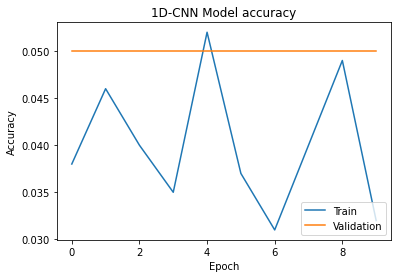

[[0.04986634 0.05005747 0.05011983 ... 0.04996265 0.04989944 0.05015147]
 [0.04986634 0.05005747 0.05011983 ... 0.04996265 0.04989944 0.05015147]
 [0.04986634 0.05005747 0.05011983 ... 0.04996265 0.04989944 0.05015147]
 ...
 [0.04986634 0.05005747 0.05011983 ... 0.04996265 0.04989944 0.05015147]
 [0.04986634 0.05005747 0.05011983 ... 0.04996265 0.04989944 0.05015147]
 [0.04986634 0.05005747 0.05011983 ... 0.04996265 0.04989944 0.05015147]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1D-CNN Accuracy of T1 on T0: 0.00 %


In [ ]:
history4=model_m.fit(train_t1_nr, y_tr_t1_cat,
          batch_size=20,
          epochs=10,
          verbose=1,
          validation_data=(test_t1_nr, y_test_t1_cat))

#Plot Accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('1D-CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


scr = model_m.predict(test_t0_nr) # We extract the score for each class ...
print(scr)
y_pred8 = np.rint(scr)     # ... and then we round it to the nearest integer
print(y_pred8)

acc8='1D-CNN Accuracy of T1 on T0: %.2f %%' % (accuracy_score(y_test_t0_cat, y_pred8)*100)
print(acc8)

## Step 7 : Conclusions

After training 1 dimension and 2 dimensions CNN classifier models on both T0 and T1 and experimenting them on cross-task evaluations. I have noted that the results are not what I expected at first. 

In [ ]:
accs = [acc, acc2, acc3, acc4, acc5, acc6, acc7, acc8]

for ac in accs:
  print (ac) 

Linear SVC Accuracy of T0 on T0: 89.50 %
Linear SVC Accuracy of T0 on T1: 5.00 %
Linear SVC Accuracy of T1 on T0: 2.00 %
Linear SVC Accuracy of T1 on T1: 5.00 %
2D-CNN Accuracy of T0 on T1: 5.00 %
2D-CNN Accuracy of T1 on T0: 0.00 %
1D-CNN Accuracy of T0 on T1: 0.00 %
1D-CNN Accuracy of T1 on T0: 0.00 %


I think that somewhere in the T1 dataset is bad reshaped because neither SVM, 1D-CNN or 2D-CNN work on T1 data or cross task recognition between T0 and T1.

I have looked into some papers online, because I was a bit stressed that my CNNs did not work, and in one of them https://iopscience.iop.org/article/10.1088/1741-2552/ac4430 they do transfer learning from all other participants excluding the subject data to recognize between 5 mental states, achieving 50% accuracy. So, it is possible that cross-task recognition is not feasible using T0 and T1 datasets, and using 20 subjects.

It has been a couple of difficult days, and I did my best to make the 1d-CNN work but and the 2d-CNN work on T1 data, but I did not succeed. Even though, I am proud and have learned a lot.






##Trying other things for later (Discarded cells)

In [ ]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense
from keras.layers import Flatten, AveragePooling2D, Input, Reshape
from keras.models import Sequential

model = Sequential()

model.add(Reshape((64, 160, 1),input_shape=(None, 64, 160)))
model.add(Convolution2D(64, (3, 1), padding='same'))
model.add(Convolution2D(64, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 1), padding='same'))
model.add(Convolution2D(128, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(256, (3, 1), padding='same'))
model.add(Convolution2D(256, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(512, (3, 1), padding='same'))
model.add(Convolution2D(512, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])


history = model.fit(X_tr,y_tr_t0,
              batch_size=100,
              epochs=10,
              validation_data=(X_ts, y_test_t0),
              shuffle=False)

In [ ]:

#Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#Plot AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('AUC (Area under Curve)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


# Plot history: Loss
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('L1/L2 Activity Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

scr = model.predict(test_nr) # We extract the score for each class ...
y_pred = np.rint(scr)     # ... and then we round it to the nearest integer
acc='CNN Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred)*100)
print(acc)
score = model.evaluate(test_nr, y_test, batch_size=250)
print(score)
print(confusion_matrix(y_test, y_pred))

In [ ]:
!pip install mne
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

#Get list of files for t0 and t1 directory
files_t0 = getListOfFiles('/content/EEG_cross/T0/')
files_t1 = getListOfFiles('/content/EEG_cross/T1/')

#Read raw data files where each file contains a run
raws_t0 = [read_raw_edf(f, preload=True) for f in files_t0]
raws_t1 = [read_raw_edf(f, preload=True) for f in files_t1]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Extracting EDF parameters from /content/EEG_cross/T0/S012R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/EEG_cross/T0/S020R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/EEG_cross/T0/S013R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/EEG_cross/T0/S007R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/EEG_cross/T0/S001R01.edf...
EDF file 

{'T0': 1}

In [ ]:
raw_obj = concatenate_raws(raws_t0)
events, event_ids = mne.events_from_annotations(raw_obj, event_id='auto')
event_ids

tmin, tmax = -1, 4  # define epochs around events (in s)


epochs = mne.Epochs(raw_obj, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)
#Access to the data
data = epochs._data

n_events = len(data) # or len(epochs.events)
print("Number of events: " + str(n_events)) 

Used Annotations descriptions: ['T0']
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 96 events and 961 original time points ...
96 bad epochs dropped
Number of events: 0


In [ ]:
data_t0 = [i._data for i in raws_t0]
data_t1 = [i._data for i in raws_t1]
labels = np.arange(0,n_classes)


n_classes = len(raws_t0)
n_channels = len(data_t0[0])
n_samples_s0 = len(data_t0[0][0])
n_samples_s1 = len(data_t0[1][0])
n_samples_s15 = len(data_t0[15][0])

print("Number of classes (subjects)  in T0: ", n_classes)
print("Number of channels  in T0: ", n_channels)
print("Number of samples  in T0, subject 0, electrode 0: ", n_samples_s0)
print("Number of samples  in T0, subject 1, electrode 0: ", n_samples_s0)
#Found that subject 15 has less samples than the other ones
print("Number of samples  in T0, subject 15, electrode 0: ", n_samples_s15)
print("\n")

#Format array to have the same shape on all subjects
min = len(data_t0[0][0])
kk = 0
for subject in data_t0:
  if (len(subject[0]) < min):
    print("Subject number:", kk, len(subject[0]))
    min = len(subject[0])
  kk += 1

data_t0_array = [[data_t0[i][j][:min] for j in range(n_channels)] for i in range(n_classes)]
#labels_array_2 = [[i for _ in range(min)] for j in range(n_channels)] for i in range(n_classes)]
#labels_array = [[[min] for j in range(n_channels)] for i in range(n_classes)]

labels_array = []
for i in range(n_classes):
  channels = []
  for j in range(n_channels):
    row = []
    for k in range(min):
      row.append(i)
    channels.append(row)
  labels_array.append(channels)


labels_array_3 = []
channels = []
for i in range(n_classes):
  for j in range(n_channels):
    row = []
    for k in range(min):
      row.append(i)
    channels.append(row)
  labels_array.append(channels)

labels_array = np.array(labels_array)
print(np.shape(labels_array))
labels_vec = labels_array.flatten()


data_t0_array = np.array(data_t0_array)
data_t0_vec = data_t0_array.flatten()

labels = np.array(labels)
print(np.shape(data_t0_array))
print(np.shape(labels))
print(np.shape(data_t0_vec))



Number of classes (subjects)  in T0:  20
Number of channels  in T0:  64
Number of samples  in T0, subject 0, electrode 0:  936160
Number of samples  in T0, subject 1, electrode 0:  936160
Number of samples  in T0, subject 15, electrode 0:  9760


Subject number: 1 9760
Subject number: 14 9600
(40,)
(20, 64, 9600)
(20,)
(12288000,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


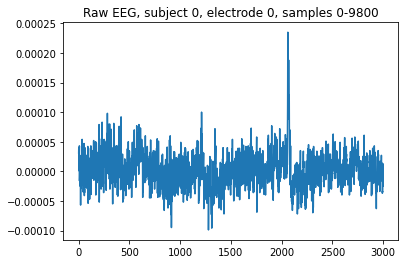

In [ ]:

plt.plot(data_t0[0][0,:3000])
plt.title("Raw EEG, subject 0, electrode 0, samples 0-9800")
plt.show()

In [ ]:
from keras.layers import Dense
from keras.layers import Flatten, AveragePooling2D, Input, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Dense(100,  activation='relu' ))
model.add(Dense(50, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy', 'AUC'])

history = model.fit(X_tr_t1,y_tr_t1,
              batch_size=20,
              epochs=10,
              validation_data=(X_ts_t1, y_test_t1),
              shuffle=False)

scr = model.predict(X_ts) # We extract the score for each class ...
y_pred4 = np.rint(scr)     # ... and then we round it to the nearest integer
acc='CNN Accuracy: %.2f %%' % (accuracy_score(y_test_t0, y_pred4)*100)
print(acc)
score = model.evaluate(X_ts, y_test_t0, batch_size=20)
print(score)
print(confusion_matrix(y_test_t0, y_pred4))


Epoch 1/10
50/50 [==============================] - 1s 9ms/step - loss: 112.6817 - accuracy: 0.0500 - auc: 0.8879 - val_loss: 110.6678 - val_accuracy: 0.0500 - val_auc: 0.5000
Epoch 2/10
50/50 [==============================] - 0s 5ms/step - loss: 107.1638 - accuracy: 0.0500 - auc: 1.0000 - val_loss: 105.8770 - val_accuracy: 0.0500 - val_auc: 0.5000
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: 105.6117 - accuracy: 0.0500 - auc: 0.9947 - val_loss: 105.5690 - val_accuracy: 0.0500 - val_auc: 0.5000
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 105.5455 - accuracy: 0.0500 - auc: 0.5000 - val_loss: 105.5344 - val_accuracy: 0.0500 - val_auc: 0.5000
Epoch 5/10
50/50 [==============================] - 0s 7ms/step - loss: 105.5261 - accuracy: 0.0500 - auc: 0.5000 - val_loss: 105.5211 - val_accuracy: 0.0500 - val_auc: 0.5000
Epoch 6/10
50/50 [==============================] - 0s 8ms/step - loss: 105.5172 - accuracy: 0.0500 - auc: 0.5000 - val_

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(data_t0_vec, labels_vec,test_size = 0.1)

#We try with Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(700,  activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

history = model.fit(X_train,y_train,
              batch_size=50,
              epochs=10,
              validation_data=(X_val, y_val),
              shuffle=True)

#Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#Plot AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('AUC (Area under Curve)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


# Plot history: Loss
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('L1/L2 Activity Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

scr = model.predict(X_test) # We extract the score for each class ...
y_pred = np.rint(scr)     # ... and then we round it to the nearest integer
acc='CNN Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred)*100)
print(acc)
score = model.evaluate(X_test, y_test, batch_size=250)
print(score)
print(confusion_matrix(y_test, y_pred))

Epoch 1/10


ValueError: ignored

In [ ]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense
from keras.layers import Flatten, AveragePooling2D, Input, Reshape
from keras.models import Sequential

model = Sequential()

model.add(Reshape((16, 16, 1),input_shape=(None, 16, 16)))
model.add(Convolution2D(64, (3, 1), padding='same'))
model.add(Convolution2D(64, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3, 1), padding='same'))
model.add(Convolution2D(128, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(256, (3, 1), padding='same'))
model.add(Convolution2D(256, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))

model.add(Convolution2D(512, (3, 1), padding='same'))
model.add(Convolution2D(512, (1, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('softmax'))